In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## 2D meshing example

This notebook shows how to mesh a 2D image:

1. Load and visualize a volume
2. Select a plane from a volume
3. Apply image filters and segment an image
4. Generate a 2D triangle mesh
5. Visualize and export the mesh to other formats

### Load and vizualize the data

Load the data from a numpy data file into a [`Volume`](https://nanomesh.readthedocs.io/en/latest/nanomesh.volume.html#nanomesh.volume.Volume) object using the `.load` method.

In [2]:
from nanomesh.volume import Volume
vol = Volume.load('sample_data.npy')

`nanomesh` makes use of [`itkwidgets`](https://github.com/InsightSoftwareConsortium/itkwidgets) to render the volumes.

In [3]:
vol.show_volume()

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

There is also a simple `matplotlib` based viewer to plot the slices of the volume. The sliders can be used to select different directions and slice numbers. Optionally, the index of the first slice can be specified directly using, for example, `x=123`.

<IPython.core.display.Javascript object>


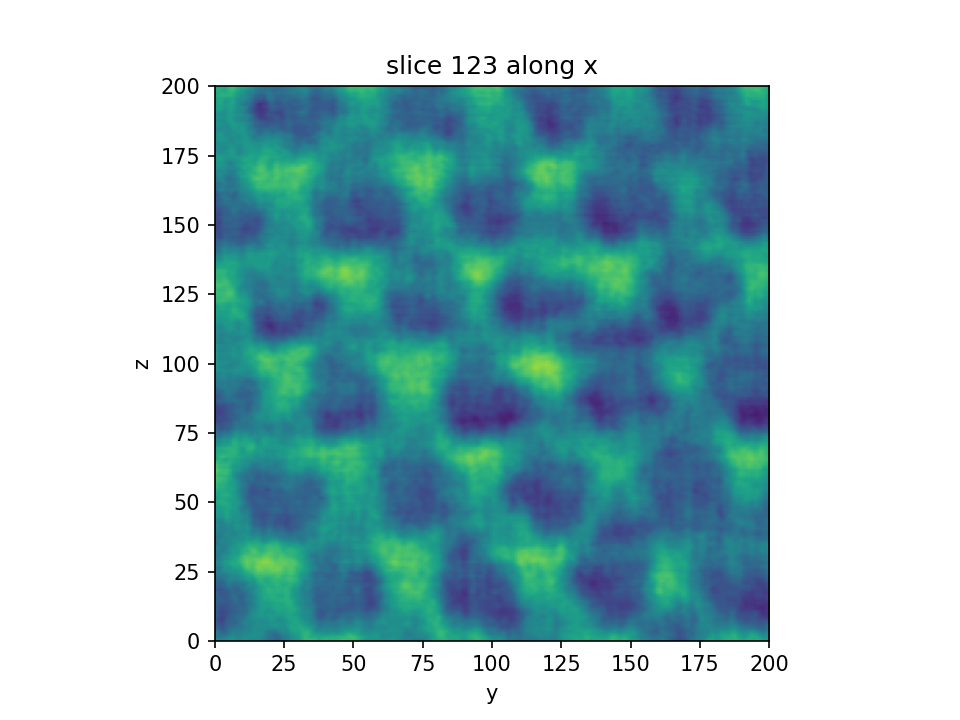

interactive(children=(IntSlider(value=123, description='index', max=199), RadioButtons(description='along', op…

In [4]:
vol.show_slice(x=123)

### Select plane from volume

Select single plane from the volume using the `.select_volume` method. In this case, we select slice #161 along the x-axis. The slice is loaded into a [`Plane`](https://nanomesh.readthedocs.io/en/latest/nanomesh.plane.html#nanomesh.plane.Plane) object.

<IPython.core.display.Javascript object>


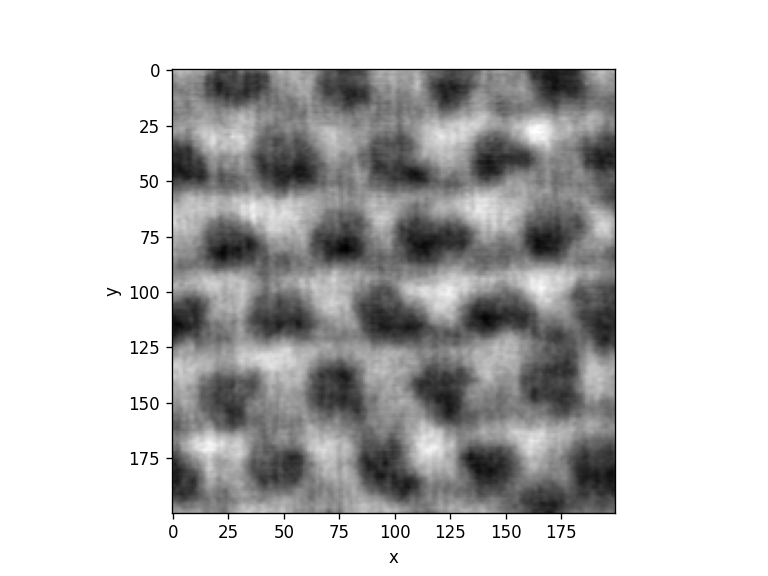

<AxesSubplot:xlabel='x', ylabel='y'>

In [5]:
plane = vol.select_plane(x=161)
plane.show()

### Filter and segment the data

Image segmentation is a way to label the pixels of different regions of interest in an image. In this example, we are interested in separating the bulk material (Si) from the nanopores. In the image, the Si is bright, and the pores are dark.

First, we apply a [`gaussian filter`](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian) to smooth out some of the image noise to get a cleaner segmentation.

**Note**: The code below is essentially short-hand for `plane_gauss = plane.apply(skimage.filters.gaussian, sigma=5)`. `apply` can be used for any operation that works on an array, i.e. from `numpy`, `scipy.ndimage` or `scikit-image`. If the output is a numpy array of the same dimensions, a `Plane` object is returned. Anything else, and it will return the direct result of the function.

<IPython.core.display.Javascript object>


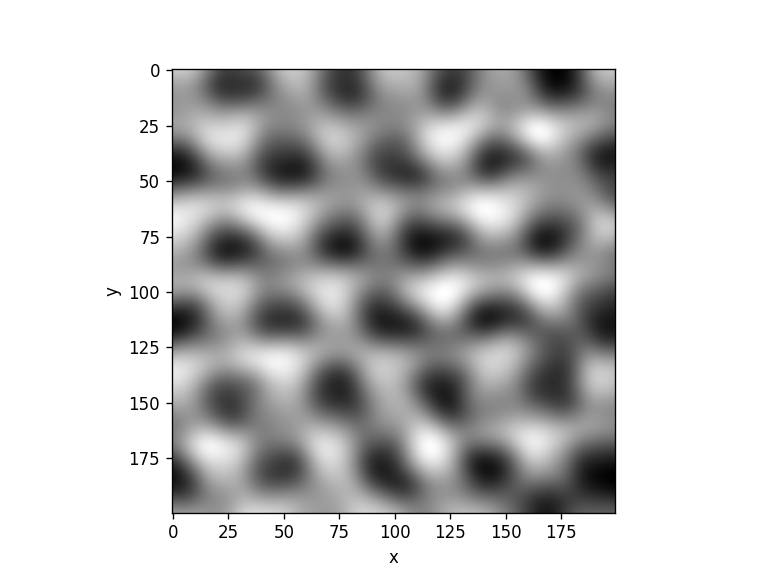

<AxesSubplot:xlabel='x', ylabel='y'>

In [6]:
plane_gauss = plane.gaussian(sigma=5)
plane_gauss.show()

Use the `compare_with_other` method to check out the difference:

<IPython.core.display.Javascript object>


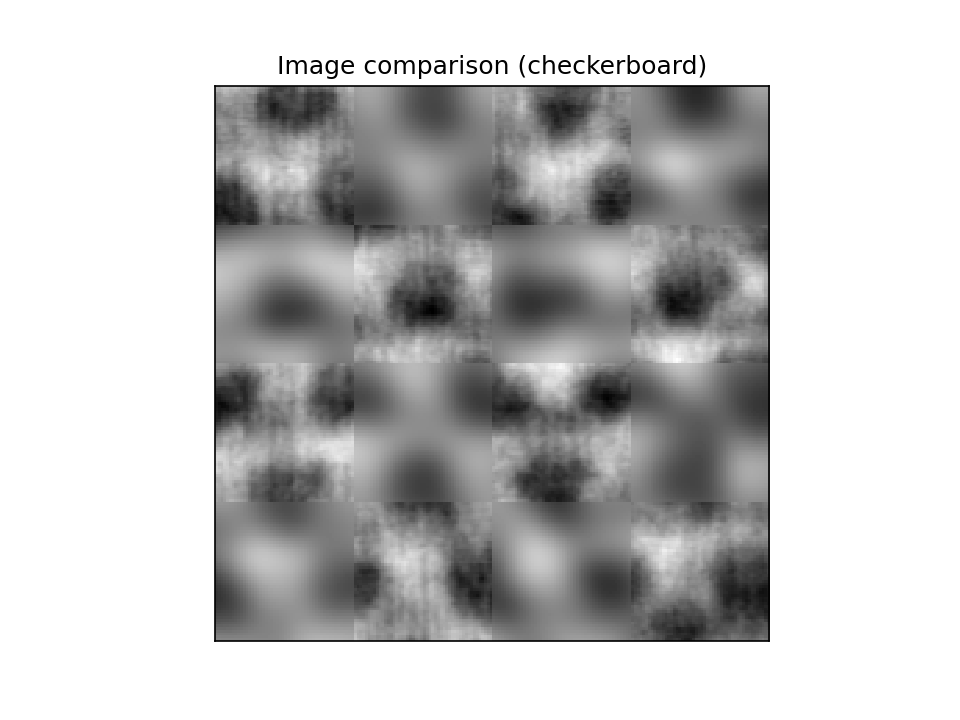

<AxesSubplot:title={'center':'Image comparison (checkerboard)'}>

In [7]:
plane.compare_with_other(plane_gauss)

`scikit-image` contains a useful function to [try all threshold finders on the data](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.try_all_threshold). These methods analyse the contrast histogram and try to find the optimal value to separate which parts of the image belong to each domain. The method below is a shortcut to this function.

Note that it is always possible to define your own threshold.

<IPython.core.display.Javascript object>


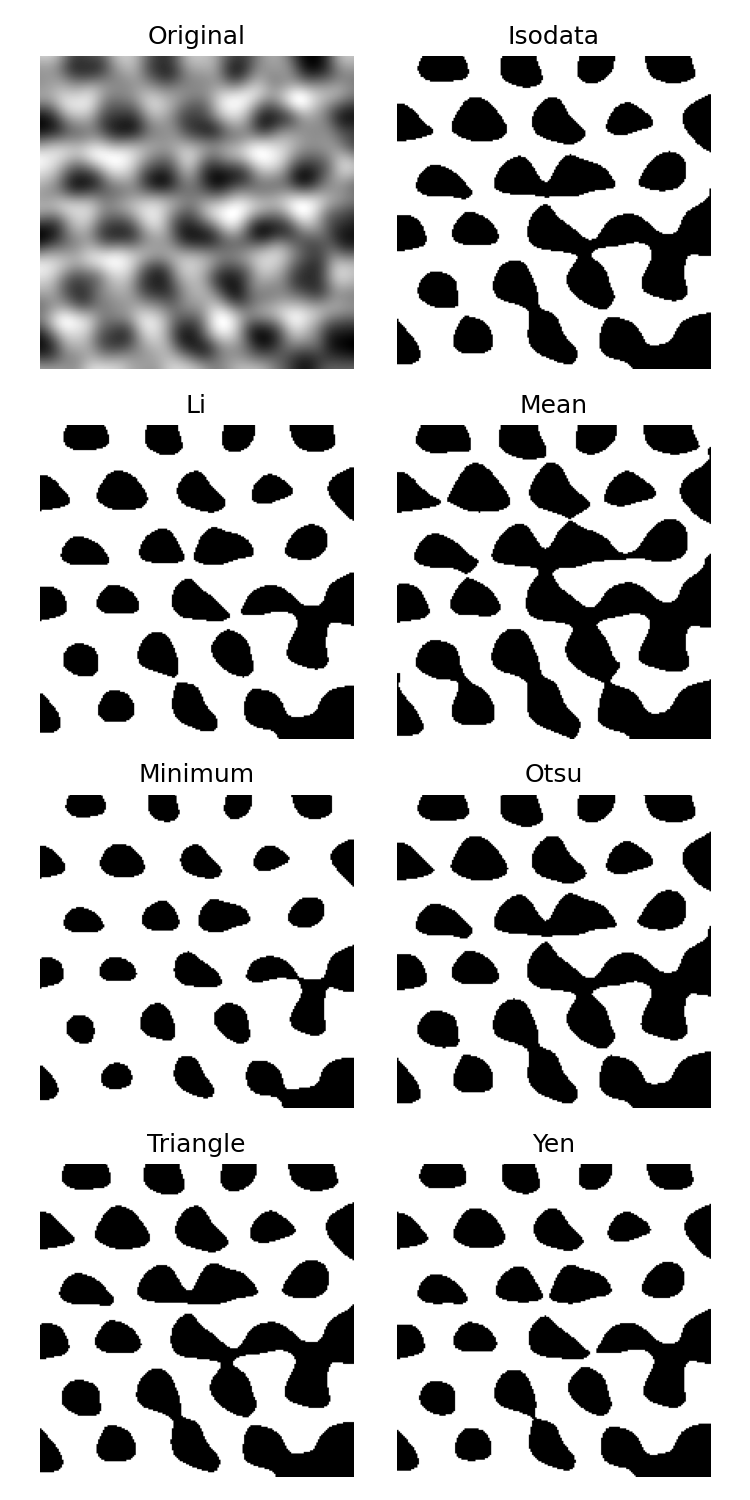

In [8]:
plane_gauss.try_all_threshold(figsize=(5, 10))

We continue with the `li` method, because it gives a result with nice separation.

In [9]:
thresh = plane_gauss.threshold('li')
thresh

0.45123855199826957

Check how the segmented image compares to the original.

<IPython.core.display.Javascript object>


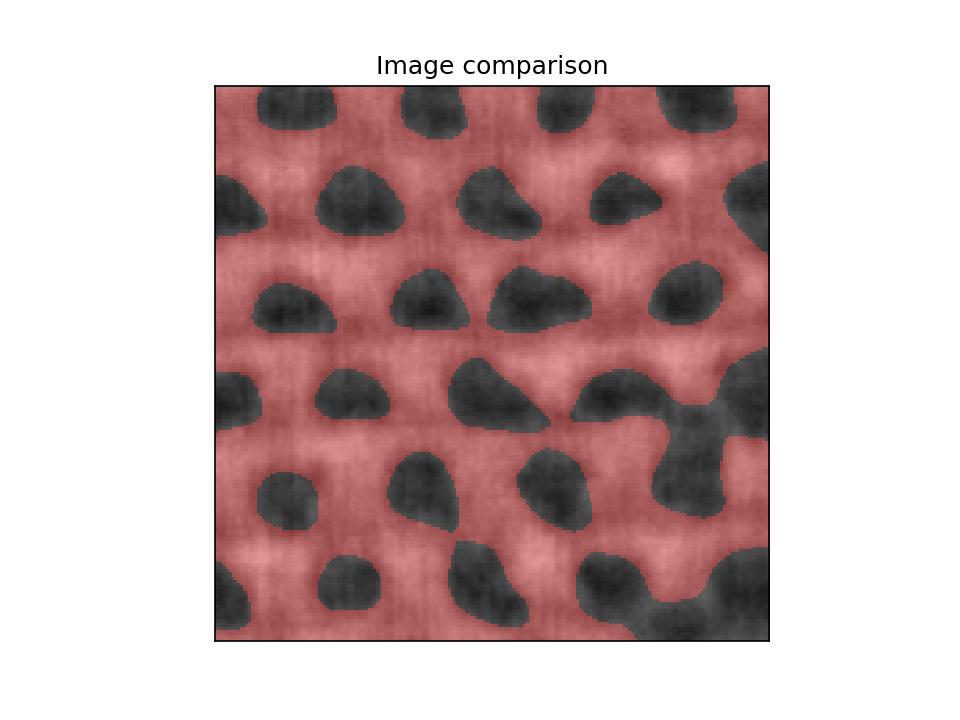

<AxesSubplot:title={'center':'Image comparison'}>

In [10]:
segmented = plane_gauss.digitize(bins=[thresh])
plane.compare_with_digitized(segmented)

### Generate mesh

Meshes are generated using the `Mesher2D` class. Meshing consists of two steps:

1. Contour finding (using the [`find_contours`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours) function
2. Triangulation (using the [`triangle`](https://rufat.be/triangle/) library)

Contour finding uses the [marching cubes algorithm](https://en.wikipedia.org/wiki/Marching_cubes) to wrap all the pores in a polygon. `max_contour_dist=5` splits up long edges in the contour, so that no two points are further than 5 pixels apart. `level` is directly passed to `find_contours` and specifies the level at which the contour is generated. In this case, we set it to the threshold value determined above.

<IPython.core.display.Javascript object>


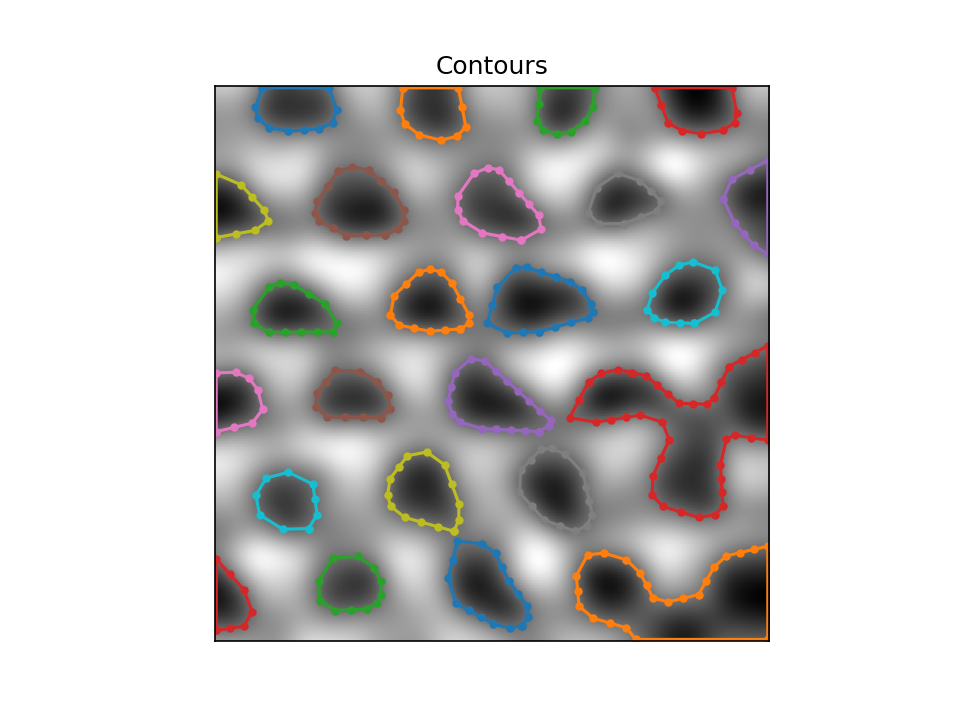

<AxesSubplot:title={'center':'Contours'}>

In [11]:
from nanomesh.mesh2d import Mesher2D

mesher = Mesher2D(plane_gauss)
mesher.generate_contours(max_contour_dist = 5, level=thresh)

mesher.plot_contour()

The next step is to use the contours to initialize triangulation.

Triangulation options can be specified through the `opts` keyword argument. This example uses `q30` to generate a quality mesh with angles > 30°, and `a100` to set a maximum triangle size of 100 pixels. For more options, see [here](https://rufat.be/triangle/API.html#triangle.triangulate).

In [12]:
mesh = mesher.triangulate(opts='q30a100')

Triangulation returns a `TriangleMesh` dataclass that can be used for various operations, for example comparing it with the original image:

<IPython.core.display.Javascript object>


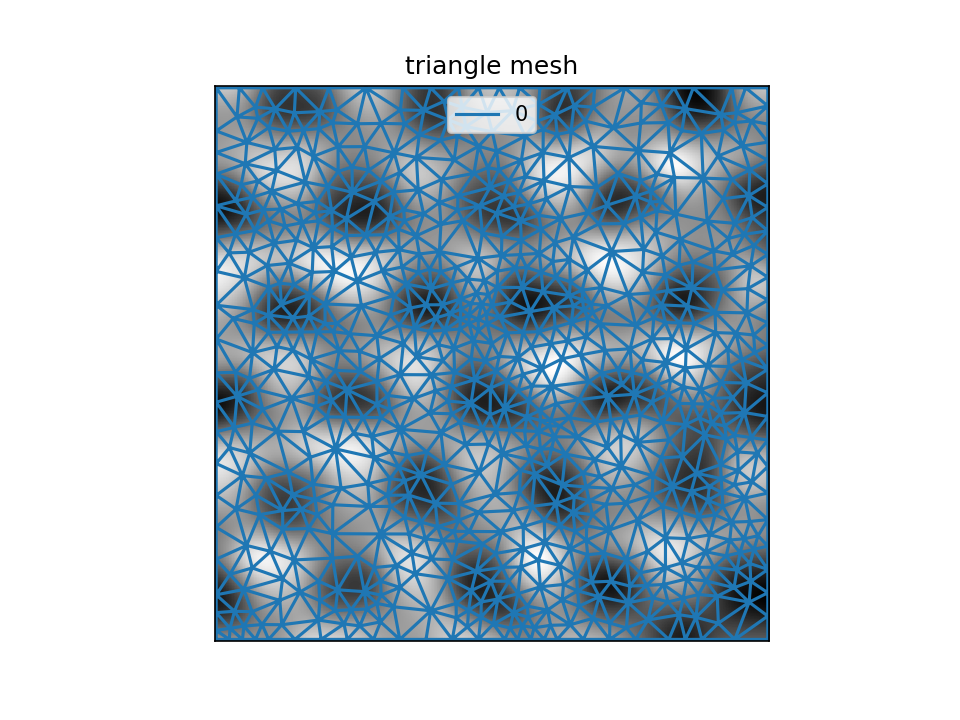

<AxesSubplot:title={'center':'triangle mesh'}>

In [13]:
plane_gauss.compare_with_mesh(mesh)

Or, showing the an interactive plot using pyvista:

(Use `.plot_itk()` for an interactive view)

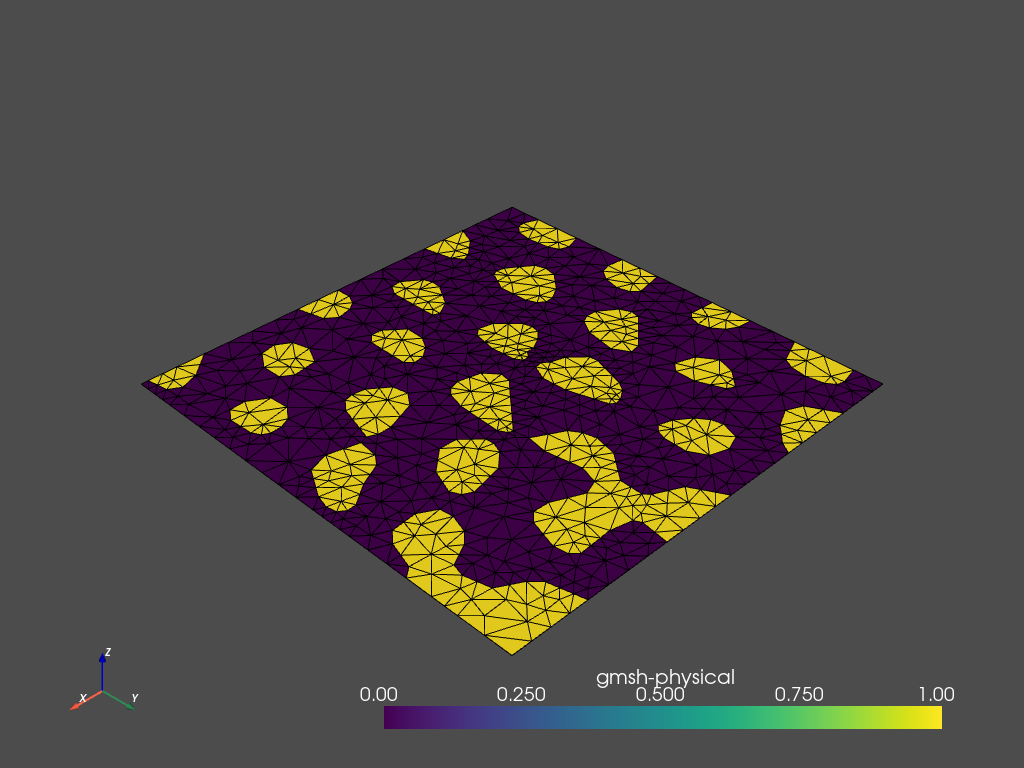

In [14]:
mesh.plot_pyvista(jupyter_backend='static', show_edges=True)

### Interoperability

The `MeshContainer` object can also be used to convert to various other library formats, such as:

- [`trimesh.Trimesh`](https://trimsh.org/trimesh.base.html#trimesh.base.Trimesh)
- [`pyvista.UnstructuredGrid`](https://docs.pyvista.org/examples/00-load/create-unstructured-surface.html)
- [`pyvista.PolyData`](https://docs.pyvista.org/api/core/_autosummary/pyvista.PolyData.html)
- [`meshio.Mesh`](https://docs.pyvista.org/examples/00-load/create-unstructured-surface.html)

First, we must extract the triangle data:

In [15]:
triangle_mesh = mesh.get('triangle')

pv_mesh = triangle_mesh.to_pyvista_unstructured_grid()
trimesh_mesh = triangle_mesh.to_trimesh()
polydata = triangle_mesh.to_polydata()
meshio_mesh = triangle_mesh.to_meshio()

To save the data, use the `.write` method. This is essentially a very thin wrapper around `meshio`, equivalent to `meshio.write(...)`.

In [16]:
mesh.write('out.msh', file_format='gmsh22', binary=False)

msh2 requires 3D points, but 2D points given. Appending 0 third component.
Appending zeros to replace the missing physical tag data.
Appending zeros to replace the missing geometrical tag data.
